In [1]:
import torch as t

import torch.nn as nn

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import torch.nn.functional as F

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('prices-split-adjusted.csv')
df = df[df.symbol == 'GOOGL']
df.index = df.date

df.drop(columns = ['date', 'symbol'], inplace = True)

df_target = df[['close']]

df_target.head()

,close
date,
2010-01-04,313.688694
2010-01-05,312.307316
2010-01-06,304.434452
2010-01-07,297.347355
2010-01-08,301.311314


In [4]:
MMS_x = MinMaxScaler()
MMS_y = MinMaxScaler()

df = MMS_x.fit_transform(df.values)
df_target = MMS_y.fit_transform(df_target.values)

In [5]:
df = pd.DataFrame(df, columns = ['open', 'close', 'low', 'high','volume'])
df_target = pd.DataFrame(df_target, columns = ['close'])
df.drop('close', axis = 1, inplace = True)
df['close'] = df_target.close

In [7]:
def make_dataset(df, seq_len, train_size = 0.9):
    feature = df.shape[1]
    x_value = df.values
    sequence_len = seq_len + 1
    data = []
    
    for i in range(len(x_value) - sequence_len):
        data.append(x_value[i : i + sequence_len])
        
    data = np.array(data)
    train_split = int(round(train_size * data.shape[0]))
    
    train_data = data[:train_split]
    test_data = data[train_split:]
    
    x_train = train_data[:, :-1]
    y_train = train_data[:, -1][:, -1]
    
    x_test = test_data[:, :-1]
    y_test = test_data[:, -1][:, -1]
    
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], feature))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], feature))
    
    return x_train, y_train, x_test, y_test

In [30]:
x_train, y_train, x_test, y_test = make_dataset(df, 24)

In [ ]:
<h2>Drop Column</h2>

In [31]:
x_train = x_train[:, :, :-1]
x_test = x_test[:, :, :-1]

In [33]:
batch_size = 1

input_size = x_train.shape[2] 

output_size = 1

In [34]:
x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          1, 
                          x_train.shape[2])

x_test = x_test.reshape(x_test.shape[0],
                        x_test.shape[1],
                        1,
                        x_test.shape[2])

In [35]:
x_test = t.tensor(x_test)
y_test = t.tensor(y_test)
x_train = t.tensor(x_train)
y_train = t.tensor(y_train)

In [36]:
class LSTM_Model(nn.Module):
    def __init__(self, input_size, output_size, n_hidden, n_layer, batch_size):
        
        super(LSTM_Model, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.n_hidden = n_hidden
        self.n_layer = n_layer
        self.batch_size = batch_size
        
        
        self.lstm = nn.LSTM(input_size, n_hidden, n_layer)
        
        
        self.linear = nn.Linear(n_hidden, output_size)
        
    def forward(self, x, hidden):
        output, hidden = self.lstm(x, hidden)
        
        out = output
        
        out = out.view(len(x), -1)
        
        out = self.linear(out)
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.n_layer,
                             batch_size,
                             self.n_hidden).zero_().to(device),
                  weight.new(self.n_layer,
                             batch_size,
                             self.n_hidden).zero_().to(device)
                 )
        
        return hidden

In [38]:
n_hidden = 256
n_layer = 1
lr = 0.001

model = LSTM_Model(input_size, output_size, n_hidden, n_layer, batch_size)

print(model)

LSTM_Model(
  (lstm): LSTM(4, 256)
  (linear): Linear(in_features=256, out_features=1, bias=True)
)


In [39]:
optimizer = t.optim.Adam(model.parameters(), lr = lr)
cri = nn.MSELoss()
device = t.device("cuda" if t.cuda.is_available() else "cpu")

device

device(type='cuda')

In [40]:
model = model.float()
x_train = x_train.float()
y_train = y_train.float()
x_test = x_test.float()
y_test = y_test.float()

In [41]:
n_epoch = 40

In [42]:
model.train()

model = model.to(device)

train_loss = []
mean_train_loss = []
x_train_pred = []

for Epoch in range(n_epoch):
    hidden_cells = model.init_hidden(batch_size)
    
    for i in range(len(x_train)):
        
        hidden_cells = tuple([e.data for e in hidden_cells])
        
        optimizer.zero_grad()
        
        x = x_train[i]
        y = y_train[i]
        x = x.to(device)
        y = y.to(device)
        
        
        y_pred, hidden_cells = model(x, hidden_cells)
        x_train_pred.append(y_pred)
        
        loss = cri(y_pred[-1], y.unsqueeze(0))
        train_loss.append(loss.item())
        loss.backward()
        
        optimizer.step()
        
        model.train()
        mean_loss = np.mean(train_loss)
        mean_train_loss.append(mean_loss)
        
    if Epoch % 10 == 0:
        print('Epoch: {}/{}'.format(Epoch, n_epoch))
        print('Training Loss {:.4f}'.format(loss.item()))

Epoch: 0/40
Training Loss 0.0070
Epoch: 10/40
Training Loss 0.0042
Epoch: 20/40
Training Loss 0.0043
Epoch: 30/40
Training Loss 0.0037


In [43]:
pred = []
model.eval()
model = model.to(device)

hidden_cells = model.init_hidden(batch_size)
for i in range(len(x_test)):
    
    hidden_cells = tuple([e.data for e in hidden_cells])
    
    x = x_test[i]
    y = y_test[i]
    x = x.to(device)
    y = y.to(device)
    
    y_pred, hidden_cells = model(x, hidden_cells)
    
    pred.append(y_pred[-1].item())

In [44]:
actual = MMS_y.inverse_transform(y_test.reshape(-1, 1))

In [45]:
pred = MMS_y.inverse_transform(np.array(pred).reshape(-1, 1))

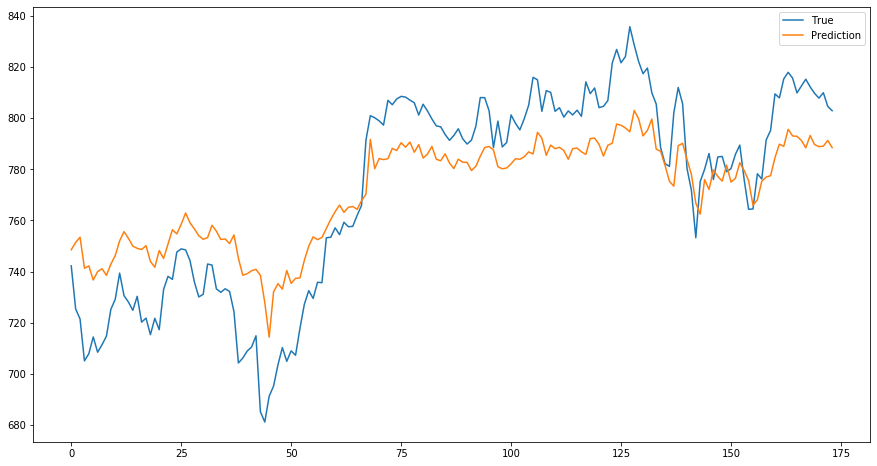

In [46]:
plt.figure(figsize = (15, 8))
plt.plot(actual, label = 'True')
plt.plot(pred, label = 'Prediction')
plt.legend()